# Making a search engine to query articles over a large dataframe.
This notebook discusses the steps taken to process a very large .csv file for querying. Such an implementation allows for efficient navigation of vast datasets, improving efficiency and providing valuable insights to their contents.

### Step 1: Loading
Before starting all other steps, it is important to have the ability to load the .csv file. A large datafile takes a long time to load into memory and is prone to cause errors and crashes due to requiring more memory than is physically available. By splitting up this singular large .csv file into multiple smaller files, it becomes easier to iteratively make changes. This occurs in load.py

### Step 2: Cleaning the data
After ensuring the new .csv files do not cause crashes due to their size, it is time to make them easier for a computer to understand. This is done through removal of information which is interesting for humans, but useless for statistical analysis. Think of punctuation or filler words like "the, a or an". This is all done in data_cleaning.py. 

Another important step is the reduction of word variants back to their dictionary form (the 'lemma' of a word). This is called "lemmatization". 'Rocks' would become 'rock' and 'standing' would become 'stand' for example. Note the ambiguity of the word standing, which refer to both standing up and the societal status of a person. Making this information unambiguous to a computer allows it to better categorize words and find patterns. 

This is a very computing-intensive process as to understand whether a 'standing' means one or the other requires contextual clues. Therefore, a random sample is first taken to reduce processing time. This sample is taken in random_sample.py. Afterwards, lemmatization.py is run. To lemmatize 2.8 million articles, it is required for a computer containing 10 cores with a processing speed of 2.1 GHz to run approximately 55 hours. The sample in contrast 'only' needs 5.5 hours to be lemmatized. This leads to step 3.

### Step 3: Converting the data into numbers
While words are interesting, they aren't numbers on which math can be performed. Therefore, lemmatized texts need to be vectorized. This vectorization allows for an extraction of prominent words which indicate the topic of their corpus (body of text). This is done through a Latent Dirichlet Allocation (LDA). By finding a Dirichlet distribution of a document, it attempts to categorize each set of vectors into a group (also known as the topic of the corpus) ([Harsh Bansal, 2020](https://medium.com/analytics-vidhya/latent-dirichelt-allocation-1ec8729589d4)). This is done in vectorizer.py.

After groups have been formed and the text has been transposed into vectors, it is possible to normalize the topic counts of each corpus and find their distribution. This allows for a comparison of an article against other articles through their similarity and differences in topic counts. This is done in doc_topic_distribution.py

### Step 4: Finding results
After the other steps are done, it is possible to search through the articles. This is done in topic_modelling.ipynb. Through a seeding article it is possible to find other articles which share a common topic space with the seed. It is also possible to input a query which the program then uses to search for articles in the topic as the query.

In [1]:
import pandas as pd
import numpy as np
import string
import os
import sys
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

sys.path.append("./datacleaning")
from load import load_years
from data_cleaning import remove_stopwords, remove_punctuation
from lemmatization import lemmatizer

sys.path.pop()
sys.path.append("./topicmodeling")
from ipynb.fs.defs.topic_modeling import print_top_words, recommendation, load_all_files, recommendation_widget

pd.options.display.max_colwidth = 100

## Step 1: Loading

### Load.py

Load.py takes [all-the-news-2-1.csv created by Andrew Thompson (2022)](https://components.one/datasets/all-the-news-2-news-articles-dataset/), and splits it into 5 seperate CSV files based on the publishing year of each article. 

The all-the-news-2-1.csv as the main file has a size of 8.8 GB resulting in long loading times. To address this, the file will be split into individual sub-files based on the year of publication. Each sub-file will contain roughly 1/5th of the data, making the processing faster and allowing for better compartmentalization. This main csv file consists of information such as publishing date, the article, its title, its writer, and the publishing url. Note that it consists mostly of American based articles, and that 2020 has only been recorded up to the month of April.

The process can be summarized as follows:

* Read the main CSV file using the pandas library.
* Split the data into separate DataFrames based on the publishing year, ranging from 2016 to 2020.
* Write the seperate Dataframes to their respective csv files.

Loading the original data

In [2]:
main_file_path = "./csv/all-the-news-2-1.csv"
years = load_years("years.txt")

def sub_file_path(year: int, version: int=0):
    """Return path to sub file.
     
     Args:
     	 year (int): year of file name.
     	 version (str): version to use for sub file. Defaults to first version.
     
     Returns: 
     	 path to sub file for given year and version.
    """
    suffix: str = ""
    if version != 0:
        suffix = "_0" + str(version)
    return f"./csv/{year}{suffix}.csv"


def convert_to_gb(value: int):
    return round(value / (1024 ** 3), 2)


def file_size(year: int, version: int=0) -> int:
    return os.stat(sub_file_path(year, version)).st_size


def load_df_version(version: int=0):
    df = {}
    for year in years:
        df.update({year: pd.read_csv(sub_file_path(year, version), nrows=10)})

    return df

A size comparison of the original .csv file and the divisions formed from it. It is possible to see that no information is lost.

In [3]:
main_files_size = convert_to_gb(os.stat(main_file_path).st_size)

print(f"{main_file_path} size: {main_files_size} GB")

cum_size = 0
for year in years:
    file = file_size(year)
    cum_size += file
    print(f"{sub_file_path(year)} {convert_to_gb(file)} GB")

print(f"Cumulative size: {convert_to_gb(cum_size)} GB")

./csv/all-the-news-2-1.csv size: 8.16 GB
./csv/2016.csv 1.74 GB
./csv/2017.csv 1.86 GB
./csv/2018.csv 1.82 GB
./csv/2019.csv 2.12 GB
./csv/2020.csv 0.63 GB
Cumulative size: 8.16 GB


An example of how information is correctly transferred fro the main file to its sub-file.

In [4]:
df_main = pd.read_csv(main_file_path, nrows=10)
df = load_df_version()

display(df_main.head(1), df[2016].head(1))

,date,year,month,day,author,title,article,url,section,publication
0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of liberal democracy seriously,"This post is part of Polyarchy, an independent blog produced by the political reform program at ...",https://www.vox.com/polyarchy/2016/12/9/13898340/democracy-warning-signs,NaN,Vox


,year,date,month,day,author,title,article,url,section,publication
0,2016,2016-12-09 18:31:00,12.0,9,Lee Drutman,We should take concerns about the health of liberal democracy seriously,"This post is part of Polyarchy, an independent blog produced by the political reform program at ...",https://www.vox.com/polyarchy/2016/12/9/13898340/democracy-warning-signs,NaN,Vox


## Step 2: Cleaning the Data

### Data_cleaning.py

As has been said in the introduction, multiple steps have to be performed so the data is interpretable by a computer. Those are all the steps in detail to understand the process.

* Articles are cast to lowercase.
    - This happens because text containing both upper and lower cases are recognized as different words.
* Commas are removed from article titles and author names.
    - Superfluous commas cause problems reading the articles. By removing them no information is lost, but processing the csv files (and each subsequent step) becauses significantly easier.
* All punctuation is removed from articles.
    - For the same reason as removing commas and casting text to lowercase.
* All stop words are removed from articles.
    - To reduce the processing power requirements for words with no inherent meaning.

#### An example of the datacleaning process
Let's take a look at the cleaning and lemmatization of a text generated through ChatGPT. First all punctuation is removed as they do not represent any interesting information. Afterwards, superfluous words (also known as stop words) are removed so there are less words to discern meaning from. Finally, the text (also known as the corpus) is reduced to their lemma.

#### Removed punctuation and stop words
This is an example of a small sample of the superfluous information contained within the datafiles that is removed.

In [5]:
display(string.punctuation + '"“‘—’”"', stopwords.words("english")[:10])

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~"“‘—’”"'

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [6]:
example_text = "The quick brown foxes jumped over the lazy dogs. They were all running and playing in the open field. The foxes' tails were bushy, and the dogs wagged their tails happily. Suddenly, a loud noise startled them, and they quickly scattered in different directions."
example_text_2 = remove_punctuation(example_text)
example_text_3 = remove_stopwords(example_text_2)
lemmatized_text = lemmatizer(example_text_3)

print(f"Unprocessed corpus:\t{example_text}\nPunctuation removed:\t{example_text_2}\nStop words removed:\t{example_text_3}\nLemmatized form:\t{lemmatized_text}")

Unprocessed corpus:	The quick brown foxes jumped over the lazy dogs. They were all running and playing in the open field. The foxes' tails were bushy, and the dogs wagged their tails happily. Suddenly, a loud noise startled them, and they quickly scattered in different directions.
Punctuation removed:	The quick brown foxes jumped over the lazy dogs They were all running and playing in the open field The foxes tails were bushy and the dogs wagged their tails happily Suddenly a loud noise startled them and they quickly scattered in different directions
Stop words removed:	The quick brown foxes jumped lazy dogs They running playing open field The foxes tails bushy dogs wagged tails happily Suddenly loud noise startled quickly scattered different directions
Lemmatized form:	the quick brown fox jump lazy dog they run play open field the fox tail bushy dog wag tail happily suddenly loud noise startle quickly scatter different direction


#### A demonstration through the project data
It becomes clear that while the text becomes less readable for people, but more readable for a computer.

In [7]:
df_cleaned = load_df_version(1)

for year in years:
    print(f"A comparison between processed and unprocessed texts of {year}:")
    display(str(df[year]['article'].head(1)), str(df_cleaned[year]['article'].head(1)))
    print("")

A comparison between processed and unprocessed texts of 2016:


'0    This post is part of Polyarchy, an independent blog produced by the political reform program at ...\nName: article, dtype: object'

'0    post part polyarchy independent blog produced political reform program new america washington th...\nName: article, dtype: object'


A comparison between processed and unprocessed texts of 2017:


'0    China is dismissing unfavorable media reports as fake news because that’s what Trump does  China...\nName: article, dtype: object'

'0    china dismissing unfavorable media reports fake news thats trump china dismissing unfavorable me...\nName: article, dtype: object'


A comparison between processed and unprocessed texts of 2018:


'0    DAVOS, Switzerland (Reuters) - U.S. President Donald Trump denied a report on Friday that he had...\nName: article, dtype: object'

'0    davos switzerland reuters us president donald trump denied report friday ordered special counsel...\nName: article, dtype: object'


A comparison between processed and unprocessed texts of 2019:


'0    PARIS (Reuters) - Former French president Nicolas Sarkozy published a new memoir on Thursday but...\nName: article, dtype: object'

'0    paris reuters former french president nicolas sarkozy published new memoir thursday quick dismis...\nName: article, dtype: object'


A comparison between processed and unprocessed texts of 2020:


'0    The lowland gorillas at the  Bronx Zoo  tend to congregate indoors during the winter rather than...\nName: article, dtype: object'

'0    lowland gorillas bronx zoo tend congregate indoors winter rather roam around outside forest habi...\nName: article, dtype: object'

This notably reduces the size of the file, which reduces the processing time of lemmatization. As lemmatization is the primary bottleneck of the data cleaning, it is paramount that as much redundant information is removed as possible. Let's take a look at the difference in file size after this data cleaning

In [8]:
def size_comparison(version: int) -> None:
    """Compare the file size of two iterations of the data files.
    
    Always compares sizes with the previous iteration.

    Args:
        version (int): Version of new data file to compare size against.
    """
    old_cum, new_cum = 0, 0
    for year in years:
        old_file_size = file_size(year, version - 1)
        new_file_size = file_size(year, version)
        old_cum += old_file_size
        new_cum += new_file_size
        print(f"{sub_file_path(year, version - 1)} was {convert_to_gb(file_size(year, version - 1))} GB, {sub_file_path(year, version)} is {convert_to_gb(file_size(year, version))} GB. The size has been decreased to {round((new_file_size/old_file_size * 100), 2)}% of the previous file.")

    print("")
    print(f"The cumulative size of the old versions was {convert_to_gb(old_cum)} GB, the new versions has a cumulative size of {convert_to_gb(new_cum)} GB.")

In [9]:
size_comparison(1)

./csv/2016.csv was 1.74 GB, ./csv/2016_01.csv is 1.24 GB. The size has been decreased to 71.57% of the previous file.
./csv/2017.csv was 1.86 GB, ./csv/2017_01.csv is 1.33 GB. The size has been decreased to 71.87% of the previous file.
./csv/2018.csv was 1.82 GB, ./csv/2018_01.csv is 1.3 GB. The size has been decreased to 71.69% of the previous file.
./csv/2019.csv was 2.12 GB, ./csv/2019_01.csv is 1.53 GB. The size has been decreased to 72.22% of the previous file.
./csv/2020.csv was 0.63 GB, ./csv/2020_01.csv is 0.45 GB. The size has been decreased to 71.6% of the previous file.

The cumulative size of the old versions was 8.16 GB, the new versions has a cumulative size of 5.86 GB.


### Random_sample.py

As has been mentioned before, the lemmatization process requires a large amount of processing power and time. The lemmatization function would require 55 hours to completely process all 5 csv files, even after reducing their contents through data_cleaning.py. Therefore, a random sample of 10% of all articles is taken from from each file and written to a new file. The smaller files require 'only' ~5-6 hours to be processed.

In [10]:
df_sampled = load_df_version(2)

size_comparison(2)

./csv/2016_01.csv was 1.24 GB, ./csv/2016_02.csv is 0.12 GB. The size has been decreased to 10.0% of the previous file.
./csv/2017_01.csv was 1.33 GB, ./csv/2017_02.csv is 0.13 GB. The size has been decreased to 10.06% of the previous file.
./csv/2018_01.csv was 1.3 GB, ./csv/2018_02.csv is 0.13 GB. The size has been decreased to 9.99% of the previous file.
./csv/2019_01.csv was 1.53 GB, ./csv/2019_02.csv is 0.15 GB. The size has been decreased to 10.01% of the previous file.
./csv/2020_01.csv was 0.45 GB, ./csv/2020_02.csv is 0.05 GB. The size has been decreased to 10.21% of the previous file.

The cumulative size of the old versions was 5.86 GB, the new versions has a cumulative size of 0.59 GB.


### Lemmatization.py
Lemmatization is a process in which words are reduced to their base dictionary form of a word (also known as their lemma) [(Stanford, 2008)](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html). This reduces the dimensionality of text, which allows for an easier classification through vectorisation [(MathWorks, 2023)](https://nl.mathworks.com/discovery/lemmatization.html). It is a very time and power intensive method but results in a trimmed text. Words which have been reduced to their lemma are more easily grouped for statistical analysis and classification as the computer reads less ambiguity.


The same is done on the articles stored in the various csv files. Due to the multi-core processing without storing original index values, the order of original has been lost after lemmatization. The articles however have been succesfully lemmatized, further reducing their size. An example of each article in their lemmatized form and the reduction in file size as an indication of superfluous information that has been removed.

In [11]:
df_lemmatized = load_df_version(3)
for year in years:
    display(df_lemmatized[year]['article'].head(1))

size_comparison(3)

0    recent rumor potential apple car may massive waste anticipatory energy well direct toward levita...
Name: article, dtype: object

0    singapore may 15 reuter golden agriresource ltds quarterly net profit fall half year ago hit for...
Name: article, dtype: object

0    washington reuter major washingtonarea airport virginia briefly halt traffic friday high wind pr...
Name: article, dtype: object

0    peoples bank china approve paypal acquisition 70 equity state gopay guofubao information technol...
Name: article, dtype: object

0    march 17 reuter icc holdings inc insurance carrier temporarily suspend billing restaurant tavern...
Name: article, dtype: object

./csv/2016_02.csv was 0.12 GB, ./csv/2016_03.csv is 0.11 GB. The size has been decreased to 88.56% of the previous file.
./csv/2017_02.csv was 0.13 GB, ./csv/2017_03.csv is 0.12 GB. The size has been decreased to 85.81% of the previous file.
./csv/2018_02.csv was 0.13 GB, ./csv/2018_03.csv is 0.12 GB. The size has been decreased to 89.99% of the previous file.
./csv/2019_02.csv was 0.15 GB, ./csv/2019_03.csv is 0.13 GB. The size has been decreased to 85.87% of the previous file.
./csv/2020_02.csv was 0.05 GB, ./csv/2020_03.csv is 0.04 GB. The size has been decreased to 83.41% of the previous file.

The cumulative size of the old versions was 0.59 GB, the new versions has a cumulative size of 0.51 GB.


## Step 3: Converting the data into numbers

### vectorizer.py & topic_modelling.ipynb

After lemmatization it is possible for the computer to convert the text to numbers. This is called data vectorization. This was performed through the sklearn Countvectorizer function. This vectorizer works through forming a sparse matrix which is a count of word occurences in a text. This matrix of vectorized text can be processed through a Latent Dirichlet Allocation. By assessing the presence of words topics can be discovered from collections of texts. Through this data it is possible to find relations between articles based on their shared topics. Let's take a look at an example.

#### An Example of spare matrix vectorization works.
By vectorizing sentences generated by ChatGPT, it is possible to see what kind of information is extracted. Below a number of words with their numerical IDs can be seen. 

('brown', 12) for example means that the word 'brown' has been assigned number 12.

The vector array cannot be displayed as easily. It is possible to convert the data to a bar graph, to take a look at the occurences of each word.

In [12]:
lemmatized_sentences = [
    "brown cat with fluffy tail jump over sleep dog in backyard",
    "I enjoy spend my weekend explore new hike trail capture beautiful photograph of nature",
    "sun set in horizon golden hue paint sky create breathtake view",
    "he passionate play piano grace and elegance captivate audience every note",
    "she dream travel world experience different culture taste exotic cuisine",
    "they decide embark on epic journey across vast ocean seek hide treasure ancient relic",
    "we gather around campfire share story laughter under star night sky",
    "it bloom vibrant color fil garden sweet scent attract butterfly bee",
    "he skillful perform intricate dance routine impress judge win heart audience",
    "she passionate pursue dream overcome obstacle achieve great success in career"
]


vectorizer = CountVectorizer()
v = vectorizer.fit(lemmatized_sentences)
vector = vectorizer.transform(lemmatized_sentences)

print("The generated sentences:")
print("\n".join([f"Sentence #{i}: {sentence}" for i, sentence in enumerate(lemmatized_sentences)]))
print("\nA short list of words and their ID value:")
items = list(v.vocabulary_.items())[:10]
print("\n".join([f"Word: {word}\tID={id}" for word, id in items]))

The generated sentences:
Sentence #0: brown cat with fluffy tail jump over sleep dog in backyard
Sentence #1: I enjoy spend my weekend explore new hike trail capture beautiful photograph of nature
Sentence #2: sun set in horizon golden hue paint sky create breathtake view
Sentence #3: he passionate play piano grace and elegance captivate audience every note
Sentence #4: she dream travel world experience different culture taste exotic cuisine
Sentence #5: they decide embark on epic journey across vast ocean seek hide treasure ancient relic
Sentence #6: we gather around campfire share story laughter under star night sky
Sentence #7: it bloom vibrant color fil garden sweet scent attract butterfly bee
Sentence #8: he skillful perform intricate dance routine impress judge win heart audience
Sentence #9: she passionate pursue dream overcome obstacle achieve great success in career

A short list of words and their ID value:
Word: brown	ID=12
Word: cat	ID=18
Word: with	ID=104
Word: fluffy	ID=3

The sparse matrix in the form of a bar chart:

<Axes: xlabel='Number of occurences', ylabel='Word'>

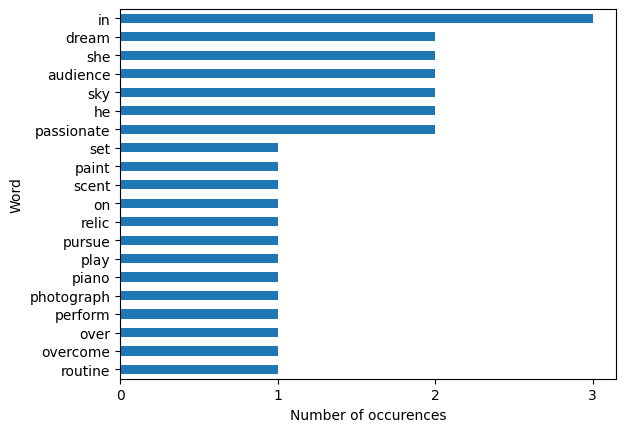

In [13]:
# most frequent words
word_count = pd.DataFrame({'word': v.get_feature_names_out(), 'count': np.asarray(vector.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh', legend=False, xlabel="Number of occurences", ylabel="Word", xticks=[0, 1, 2, 3])

#### An example of applying the LDA to a vectorized corpus.
By applying the LDA on the sentences, it is possible to discover groups in the sentences.

In [14]:
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(vector)

print_top_words(lda, vectorizer, n_top_words=5)

Topic 0: embark treasure seek journey epic
Topic 1: sky in star under laughter
Topic 2: in she dream passionate great



From this, it is visible that the randomly generated sentences do not tend to share any common topic space. Topic 0 is from sentence #5

In [15]:
print(lemmatized_sentences[5])

they decide embark on epic journey across vast ocean seek hide treasure ancient relic


#### Vectorization and applying of the LDA on the actual dataset
All aforementioned steps have already been performed, as they will otherwise take a long time to be done in this notebook. Expect a runtime of 1.5 to 2 hours when vectorizing, applying the LDA and normalizing topic distribution per corpus. It is therefore only neccessary to load the files into this notebook.

In [16]:
topic_modelling_data = load_all_files("topicmodeling/csv", "csv", years)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.


#### An example of topic distribution per year of the dataset.

Each topic consists of a set of words.

In [17]:
for year in years:
    print(year)
    print_top_words(topic_modelling_data["lda"][year], topic_modelling_data["vectorizer"][year], n_top_words=5)

2016
Topic 0: use like make new not
Topic 1: say police court case officer
Topic 2: song music album band record

2017
Topic 0: like not make get one
Topic 1: percent price stock say high
Topic 2: 2017 music song album band

2018
Topic 0: woman man people one not
Topic 1: not do get go like
Topic 2: 2018 get star year not

2019
Topic 0: year growth economy say rate
Topic 1: health say drug care patient
Topic 2: woman film show black story

2020
Topic 0: de la que en el
Topic 1: iran we say iranian united
Topic 2: datum company say business use



#### The distribution of words per year.
It is possible to take a look at the word distribution of each year to have an insight into what possible topics are relevant that year. It is noticable that 'say' occurs very often in each year. Say could reasonably be interpreted as a stop word which would be removed in another version of text processing. In 2016-2017 it is seen that 'trump' ranks relatively high, which is in line with the presidential elections occuring at the time.

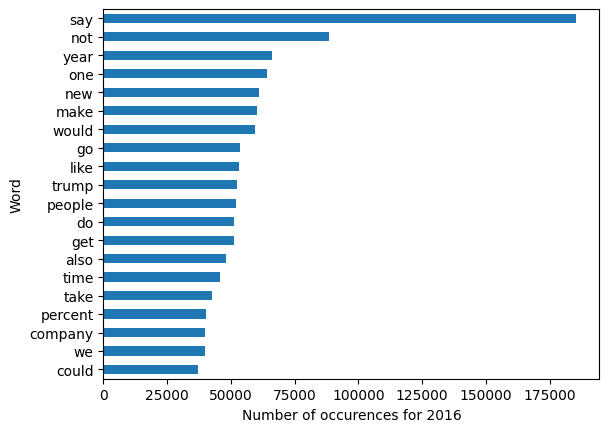

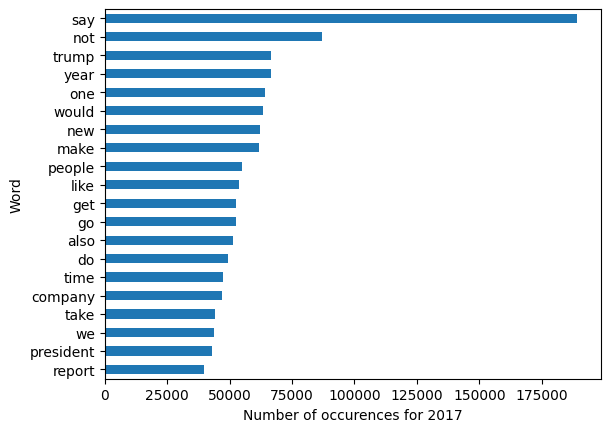

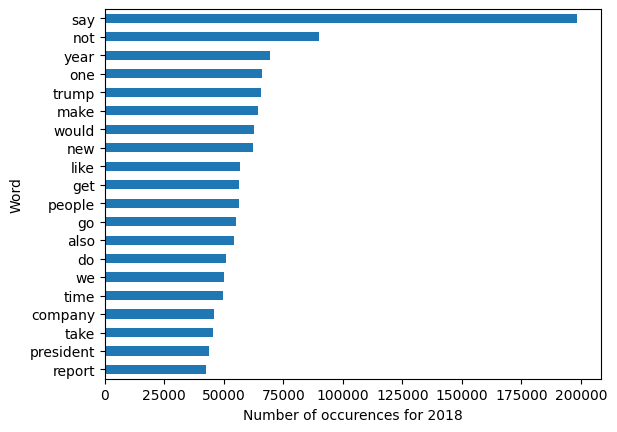

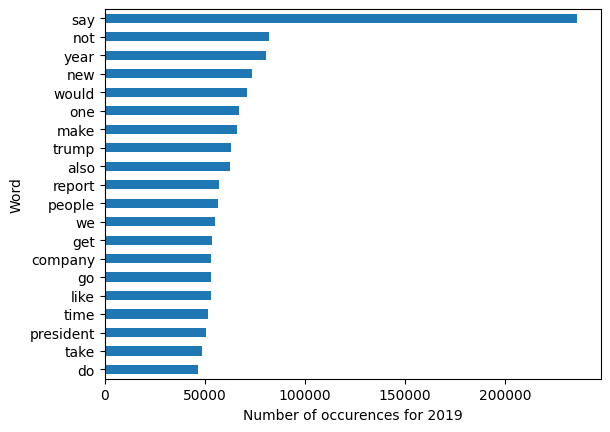

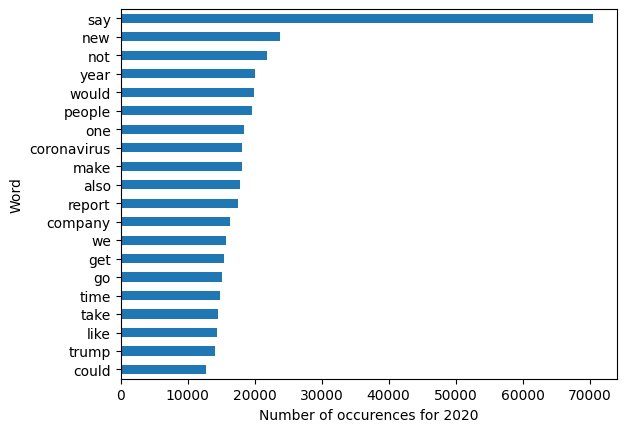

In [18]:
for year in years:
    word_count = pd.DataFrame({'word': topic_modelling_data["vectorizer"][year].get_feature_names_out(), 'count': np.asarray(topic_modelling_data["data_vectorized"][year].sum(axis=0))[0]})
    word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh', legend=False, xlabel=f"Number of occurences for {year}", ylabel="Word")

#### The result of this data processing

After all this processing it is possible to query the dataset to find relevant articles through a provided article, also known as the seeding article. This returns a number of articles with their hyperlink alongside a similarity value (ranging from 0 to 1) indicating the overlap in topic space between the seeding article and the recommended article.

In [19]:
recommendation(topic_modelling_data, 2020, "U.S. manufacturing output rises unexpectedly", number_of_related_articles=10)

,year,date,month,day,author,title,article,url,section,publication
3,2020,2020-01-17 00:00:00,1.0,17,NaN,U.S. manufacturing output rises unexpectedly,washington reuter we manufacture output rise unexpectedly december drop motor vehicle output out...,https://www.reuters.com/article/us-usa-economy-output/us-manufacturing-output-rises-unexpectedly...,Business News,Reuters


It seems that the seeding article is mostly about topic number 11, 27 and 43 with some other topics sparsely mentioned. Taking a look at the topics seems to confirm that those topics are indeed what the seeding article is about.

In [20]:
feature_names = topic_modelling_data["vectorizer"][2020].get_feature_names_out()
dist = list(enumerate(topic_modelling_data["lda"][year].components_))

for topic_id, topic in (dist[11:12] + dist[27:28] + dist[43:44]):
    message = f"Topic {topic_id}: "
    message += " ".join([feature_names[i] for i in topic.argsort()[: -5 - 1 : -1]])
    print(message)
print()

Topic 11: year say growth price rate
Topic 27: say vehicle car production tesla
Topic 43: oil say energy gas climate



#### The implementation in a widget
It is possible to go one step further, as sometimes it is not possible to have a seeding article that a search can be based on. Through accepting a text as input by a user, it becomes possible to place this in the topic distributions, which allows a direct search of the database. The user can specify the number of articles, and the year to query. It accepts any form of text, ranging from numbers, to words to entire articles. This input is vectorized and fit to the LDA after which articles with similar topic distribution are returned.

In [21]:
recommendation_widget(topic_modelling_data)

##